# Имплементация решения матричной игры с помощью симплекс-метода

## Подготовка

    Подключение необходимых подпроектов 
    - lib.simplex_method
    - utils.matrix_stuff

    А также библиотеки matplotlib для построения графиков. Для удобства прописана директива для     
    препроцессора IPython Notebook о требовании встраивать результат работы библиотеки matplotlib

In [1]:
%matplotlib inline

import sys

import lib.simplex_method
import utils.matrix_stuff
import matplotlib.pyplot as plotter

## Обработка ввода

    Данный блок необходим для поддержки возможности считывать матрицу из консоли

In [2]:
def source_input():
    ''' 
    Prints start information, read source data.
    Returns matrix, count of rows and columns
    '''
    print("********************************************************")
    print("Input source data")
    try:
        N = int(input("Count of strategies of 1 player: "))
        M = int(input("Count of strategies of 2 player: "))
        print("Enter the game matrix:")
        matrix = []
    
        i = 0
        while i < N:
            row = input().split()
            assert len(row) == M
            matrix.append([float(j) for j in row])
            i += 1
    except AssertionError:
        print("Wrong count of column")
        sys.exit()
    except ValueError:
        print("Wrong type of value")
        sys.exit()
    return N, M, matrix

## Подготовка матрицы

    В данной функции матрица обрабатывается следующим образом:

    1) Удаляются доминирующие стратегии. 
    2) Матрица приводится к матрице, содержащей только положительные элементы

    Данная функция возвращает значение минимального элемента матрицы.

In [3]:
def prepare_matrix(matrix, indexes1, indexes2, n, m, enable_rows_and_columns_elimination = 0):
    ''' 
    matrix = list[list[float]]; copy of source_matrix
    indexes1 = list[int]; usable indexes of rows
    indexes2 = list[int]; usable indexes of columns
    n = int: count of strategies of first player
    m = int: count of strategies of second player
    enable_rows_and_columns_elimination = bool: 
        enables dominated or equal rows and columns elimination
    ---------------------------------------------
    Delete dominated strategies, transform to matrix with only positive elements.
    Returns the value of minimal element in matrix
    '''
    
    if (enable_rows_and_columns_elimination):
        utils.matrix_stuff.delete_dominated_n_equal(matrix, indexes1, indexes2, n, m)
    
    n = len(matrix)
    m = len(matrix[0])

    min_el = matrix[0][0]
    is_any_negative = False

    for i in range(n):
      for j in range(m):
          if matrix[i][j] < 0:
              is_any_negative = True
          min_el = min(min_el, matrix[i][j])
    
    if is_any_negative:
        for i in range(n):
            for j in range(m):
                matrix[i][j] -= min_el

    return min(min_el, 0)

## Построение графиков

    Функция занимающаяся построением спектра для каждого игрока.

In [4]:
def plot (game_plot, player_no):
    fig = plotter.figure(figsize=(10, 10))
    ax1 = fig.add_subplot(211)
    ax1.stem(range(1, len(game_plot) + 1), game_plot, use_line_collection=True)
    fig.suptitle("Vector of optimal strategies for player{}".format(player_no), fontsize=16)

## Приведение матрицы к задаче линейного программирования и решение.

    В данной функции преобразованная матрица приводится к задаче линейного программирования, которую мы 
    решаем с помощью симплекс-метода. 
    
    Данная функция возвращает симплекс-таблицу.

In [5]:
def get_simplex(matrix, n, m, pl_type = 0):
    '''
    matrix = list[list[float]]: modified matrix of game
    n = int: count of rows
    m = int: count of columns
    pl_type = int: 0 - first player, 1 - second player
    Cast modified matrix of game to linear programming task and run simplex-method.
    Returns result simplex-table
    '''
    lp_matrix = []

    if pl_type == 0:
        for i in range(m):
            row = []
            for j in range(n):
                row.append(matrix[j][i])
            lp_matrix.append(row)
    else:
        for i in range(n):
            row = []
            for j in range(m):
                row.append(matrix[i][j])
            lp_matrix.append(row)
    
    return lib.simplex_method.run_simplex(lp_matrix, pl_type)

## Интерфейс для тестирования

    Данная функция предоставляет интерфейс для тестирования, получая на вход матрицу игры и выводя 
    решение.

In [6]:
def nash_equilibrium(source_n, source_m, source_matrix):
    ''' 
    main function
    '''
    matrix = source_matrix.copy()
    n, m = source_n, source_m
    
    indexes1 = list(range(n))
    indexes2 = list(range(m))
    
    min_el = prepare_matrix(matrix, indexes1, indexes2, n, m, 1)
    
    n = len(matrix)
    m = len(matrix[0])
    
    simplex_matrix1 = get_simplex(matrix, n, m, 0)
    simplex_matrix2 = get_simplex(matrix, n, m, 1)
    
    target_f = 0
    target_plan1 = [0] * (len(simplex_matrix1[0]) - 2)
    target_plan2 = [0] * (len(simplex_matrix2[0]) - 2)
    for i in range(1, len(simplex_matrix1)):
        curr_value = simplex_matrix1[i][len(simplex_matrix1[i]) - 1]
        target_plan1[simplex_matrix1[i][0] - 1] = curr_value
        target_f += curr_value * simplex_matrix1[0][simplex_matrix1[i][0]]

        curr_value = simplex_matrix2[i][len(simplex_matrix2[i]) - 1]
        target_plan2[simplex_matrix2[i][0] - 1] = curr_value
    
    V = 1 / target_f
    print("Target F = {}".format(target_f))
    print("Then V = {}".format(V))
    
    if min_el != 0:
        V = 1 / target_f - min_el
        print("Source matrix was modified by adding min_el = {}".format(min_el))
        print("V = V' - min_el = {}".format(V))
    
    first_player_tactics = []
    it = 0
    
    for i in range(source_n):
        if it < len(indexes1) and i == indexes1[it]:
            first_player_tactics.append(target_plan1[it] * V)
            it += 1
        else:
            first_player_tactics.append(0)
    
    second_player_tactics = []
    it = 0

    for i in range(source_m):
        if it < len(indexes2) and i == indexes2[it]:
            second_player_tactics.append(target_plan2[it] * V)
            it += 1
        else:
            second_player_tactics.append(0)
    
    print("First player tactics: {}".format(first_player_tactics))
    print("Second player tactics: {}".format(second_player_tactics)) 

    plot(first_player_tactics, 1)   
    plot(second_player_tactics, 2)

# Тестирование

    Для тестирования рассмотрим несколько принципально различных матричных игр. Будем различать игры по 
    выходному результату.

    1) Спектр оптимальной стратегии состоит из одной точки (т.е существует равновесие Нэша в чистых
    стратегиях). 

    Пример игры:

    1  4 1
    2  3 4
    0 -2 7

    2) Cпектр оптимальной стратегии неполон (т.е. некоторые чистые стратегии не используются)

        a) Из-за наличия доминируемых чистых стратегий
        
        Пример игры:

        2 4 5
        0 5 1
        4 5 1

        b) Из-за наличия доминируемых смешанных стратегий

        Пример игры:

        1 4 6
        7 2 0
        5 3 2

        c) Спектр оптимальной стратегии полон:

        Пример игры:

        4 2 2
        2 5 0
        0 2 5
    

## Спектр оптимальной стратегии состоит из одной точки (т.е существует равновесие Нэша в чистых стратегиях)

Target F = 0.5
Then V = 2.0
First player tactics: [0, 1.0, 0]
Second player tactics: [1.0, 0, 0]


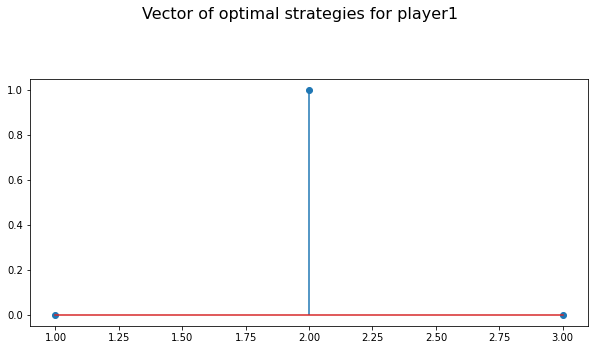

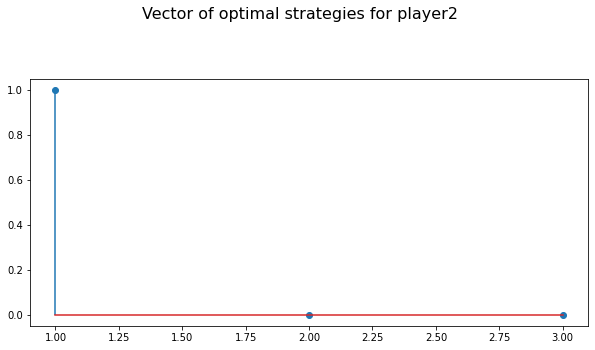

In [7]:
source_n = 3
source_m = 3
source_matrix = [[1, 4, 1],
                [2, 3, 4],
                [0, -2, 7]]
nash_equilibrium(source_n, source_m, source_matrix)

### Cпектр оптимальной стратегии неполон (т.е. некоторые чистые стратегии не используются) из-за наличия доминируемых чистых стратегий

Target F = 0.33333333333333337
Then V = 2.9999999999999996
First player tactics: [0.4999999999999999, 0, 0.5]
Second player tactics: [0.6666666666666665, 0, 0.33333333333333326]


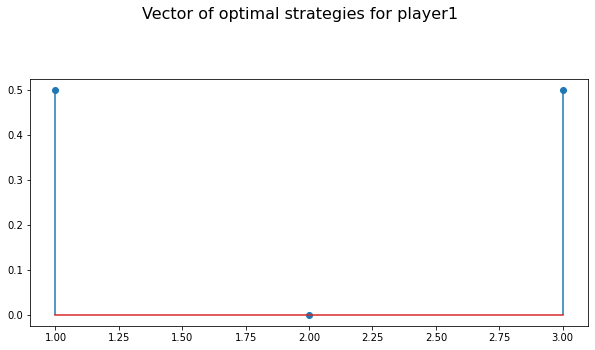

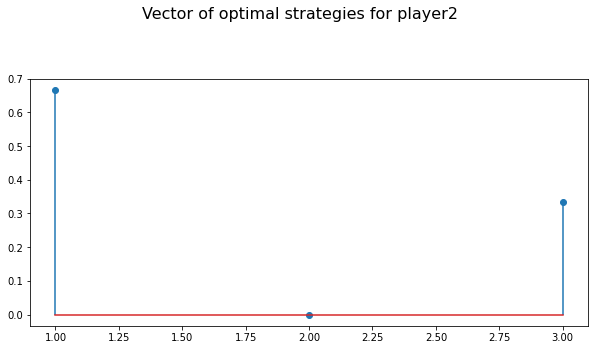

In [8]:
source_n = 3
source_m = 3
source_matrix = [[2, 4, 5],
                [0, 5, 1],
                [4, 5, 1]]
nash_equilibrium(source_n, source_m, source_matrix)

### Cпектр оптимальной стратегии неполон (т.е. некоторые чистые стратегии не используются) из-за наличия доминируемых смешанных стратегий

Target F = 0.2941176470588235
Then V = 3.4000000000000004
First player tactics: [0.4000000000000001, 0.0, 0.5999999999999999]
Second player tactics: [0.19999999999999993, 0.8, 0.0]


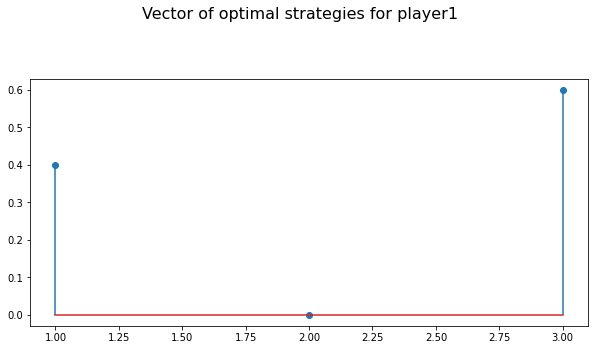

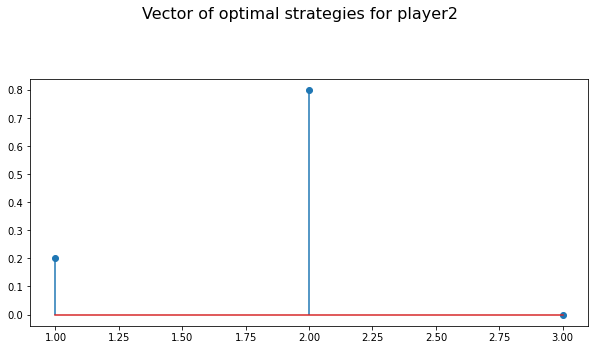

In [9]:
source_n = 3
source_m = 3
source_matrix = [[1, 4, 6],
                [7, 2, 0],
                [5, 3, 2]]
nash_equilibrium(source_n, source_m, source_matrix)

### Cпектр оптимальной стратегии полон

Target F = 0.3977272727272727
Then V = 2.5142857142857142
First player tactics: [0.5428571428571428, 0.1714285714285714, 0.2857142857142857]
Second player tactics: [0.2571428571428572, 0.39999999999999997, 0.3428571428571428]


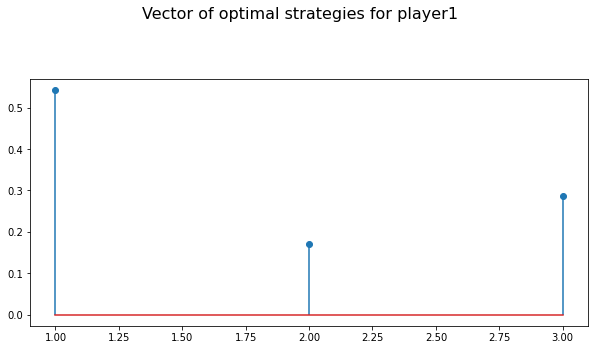

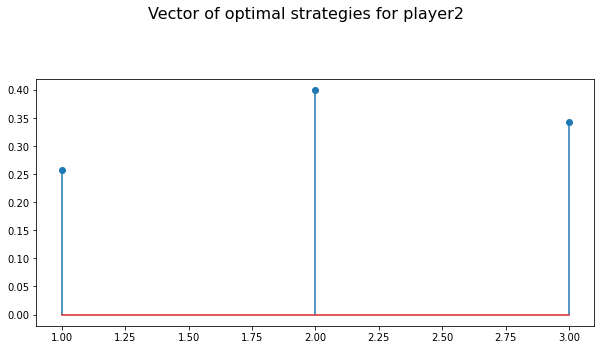

In [10]:
source_n = 3
source_m = 3
source_matrix = [[4, 2, 2],
                [2, 5, 0],
                [0, 2, 5]]
nash_equilibrium(source_n, source_m, source_matrix)